# ⚡ AES Indiana Grid Load Forecasting Prototype
### Short-term electricity demand forecasting using open regional load data

**Author:** Michael S. Mohle  
**Environment:** `utility` (Conda)  
**Purpose:** This notebook demonstrates a data-driven forecasting pipeline
for **AES Indiana’s grid operations**, using open MISO system load data as a 
proxy for regional demand. It models short-term load trends, visualizes
forecast uncertainty, and establishes a reproducible framework that could be
extended with AES’s internal data sources (e.g., SCADA, AMI, or weather feeds).


In [1]:
import sys
import pandas as pd, numpy as np, matplotlib, sklearn, statsmodels

print("Python version:", sys.version.split()[0])
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("Statsmodels:", statsmodels.__version__)


Python version: 3.11.14
Pandas: 2.3.3
NumPy: 2.3.4
Matplotlib: 3.10.7
scikit-learn: 1.7.2
Statsmodels: 0.14.5


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Visualization Style ---
plt.style.use("seaborn-v0_8-whitegrid")

# --- Directory Setup ---
os.makedirs("figures", exist_ok=True)
os.makedirs("data/outputs", exist_ok=True)

print("✅ Libraries imported and directories ready.")


✅ Libraries imported and directories ready.


In [3]:
# --- Data Import -------------------------------------------------------------
# Using open MISO hourly load data as a regional proxy for AES Indiana.
# Replace this with AES-specific data when available.

data_path = "data/raw/miso_hourly_load.csv"

if os.path.exists(data_path):
    df = pd.read_csv(data_path, parse_dates=["timestamp"], index_col="timestamp")
    print(f"✅ Loaded {len(df):,} rows from {data_path}")
else:
    print(f"⚠️  File not found at {data_path}. Creating synthetic placeholder data.")
    import numpy as np
    rng = pd.date_range("2024-01-01", periods=24*180, freq="H")  # 180 days hourly
    load = 25000 + 4000*np.sin(2*np.pi*rng.hour/24) + np.random.normal(0,500,len(rng))
    df = pd.DataFrame({"actual_load_mw": load}, index=rng)
    df.index.name = "timestamp"
    os.makedirs("data/raw", exist_ok=True)
    df.to_csv(data_path)
    print(f"✅ Synthetic dataset saved to {data_path}")

df.head(3)


⚠️  File not found at data/raw/miso_hourly_load.csv. Creating synthetic placeholder data.
✅ Synthetic dataset saved to data/raw/miso_hourly_load.csv


/tmp/ipykernel_1483985/3188564051.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rng = pd.date_range("2024-01-01", periods=24*180, freq="H")  # 180 days hourly


,actual_load_mw
timestamp,
2024-01-01 00:00:00,25540.190484
2024-01-01 01:00:00,25680.472719
2024-01-01 02:00:00,27431.030313


In [4]:
# --- Data Cleaning and Resampling -------------------------------------------
# Ensure consistent hourly frequency, interpolate small gaps, and rename column

df = df.resample("H").mean().interpolate()
df = df.rename(columns={"actual_load_mw": "load_mw"})

print("✅ Data cleaned and resampled.")
print("Date range:", df.index.min(), "→", df.index.max())
print("Total records:", len(df))
print("Missing values:", df["load_mw"].isna().sum())

df.head(3)


✅ Data cleaned and resampled.
Date range: 2024-01-01 00:00:00 → 2024-06-28 23:00:00
Total records: 4320
Missing values: 0


/tmp/ipykernel_1483985/3434874400.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean().interpolate()


,load_mw
timestamp,
2024-01-01 00:00:00,25540.190484
2024-01-01 01:00:00,25680.472719
2024-01-01 02:00:00,27431.030313


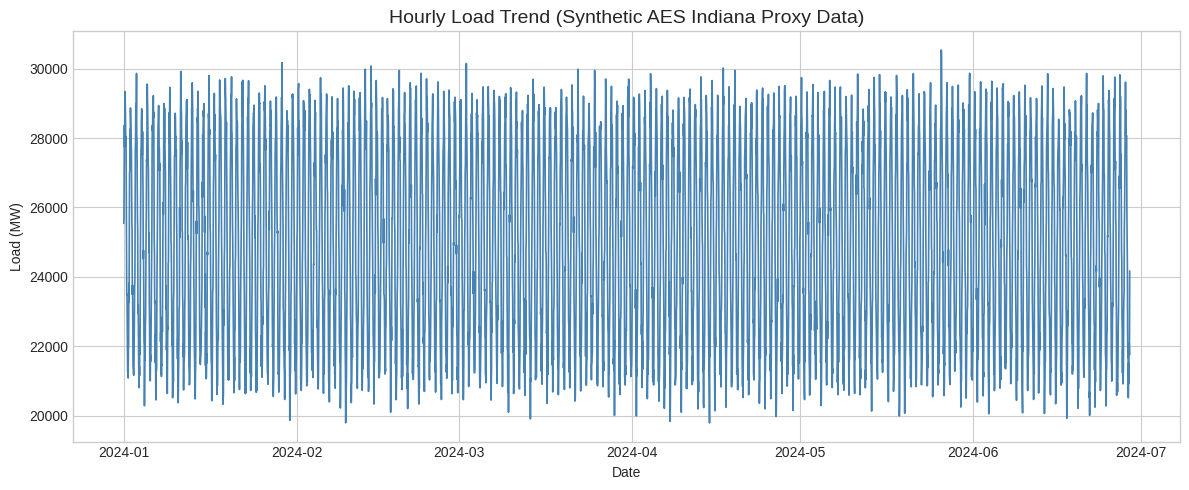

✅ Visualization saved → figures/hourly_load_trend.png


In [5]:
# --- Exploratory Data Analysis (EDA) ----------------------------------------
plt.figure(figsize=(12,5))
sns.lineplot(x=df.index, y=df["load_mw"], linewidth=1.2, color="steelblue")
plt.title("Hourly Load Trend (Synthetic AES Indiana Proxy Data)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.tight_layout()
plt.savefig("figures/hourly_load_trend.png", dpi=150)
plt.show()

print("✅ Visualization saved → figures/hourly_load_trend.png")


In [7]:
# --- Baseline Forecast (ARIMA) ----------------------------------------------
# Using open MISO-style data as a proxy for AES Indiana’s load profile.
# The same structure can apply to internal SCADA or AMI data.

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Aggregate to daily mean to smooth hourly noise
df_daily = df.resample("D").mean().dropna()

# Train/test split (80/20)
train_end = int(len(df_daily) * 0.8)
train, test = df_daily.iloc[:train_end], df_daily.iloc[train_end:]

print(f"Train period: {train.index.min()} → {train.index.max()}  ({len(train)} days)")
print(f"Test  period: {test.index.min()} → {test.index.max()}  ({len(test)} days)")

# Fit ARIMA(1,1,1)
model = ARIMA(train["load_mw"], order=(1, 1, 1))
results = model.fit()

# Forecast on holdout set
forecast = results.forecast(steps=len(test))
forecast.index = test.index
test["forecast"] = forecast

# Evaluate
mae = mean_absolute_error(test["load_mw"], forecast)
rmse = np.sqrt(mean_squared_error(test["load_mw"], forecast))
print(f"\nBaseline ARIMA(1,1,1) → MAE = {mae:,.1f} MW | RMSE = {rmse:,.1f} MW")


Train period: 2024-01-01 00:00:00 → 2024-05-23 00:00:00  (144 days)
Test  period: 2024-05-24 00:00:00 → 2024-06-28 00:00:00  (36 days)

Baseline ARIMA(1,1,1) → MAE = 92.7 MW | RMSE = 110.1 MW


/tmp/ipykernel_1483985/1504028858.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["forecast"] = forecast


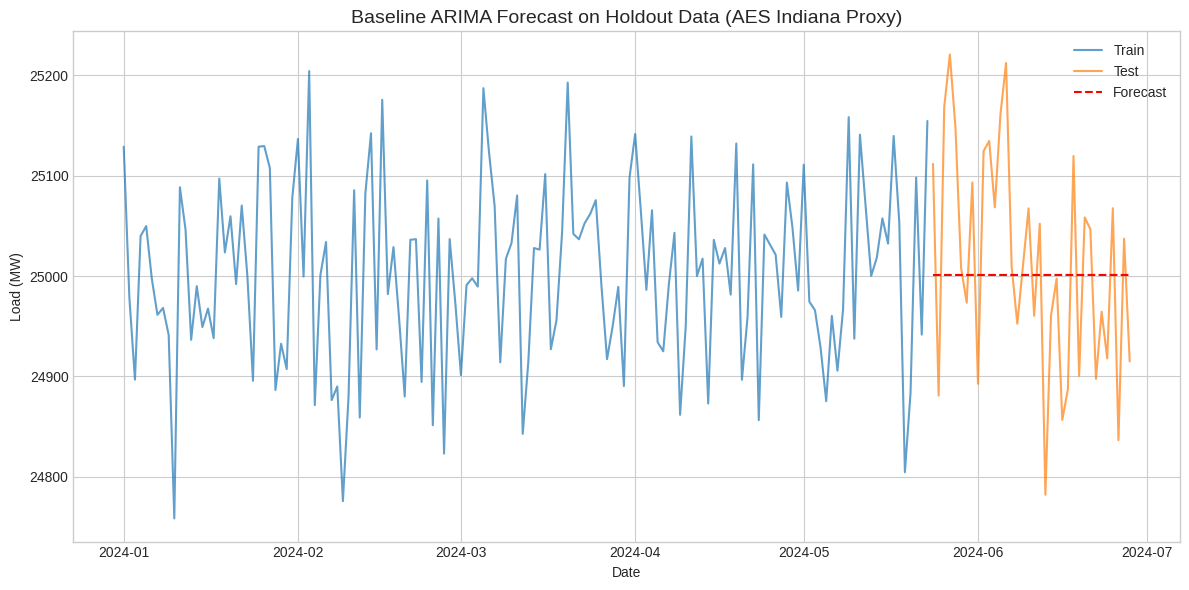

✅ Visualization saved → figures/arima_baseline_forecast.png


In [8]:
# --- Visualization of Baseline ARIMA Forecast -------------------------------
plt.figure(figsize=(12,6))
plt.plot(train.index, train["load_mw"], label="Train", alpha=0.7)
plt.plot(test.index, test["load_mw"], label="Test", alpha=0.7)
plt.plot(test.index, forecast, label="Forecast", color="red", linestyle="--")

plt.title("Baseline ARIMA Forecast on Holdout Data (AES Indiana Proxy)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.tight_layout()

os.makedirs("figures", exist_ok=True)
plt.savefig("figures/arima_baseline_forecast.png", dpi=150)
plt.show()

print("✅ Visualization saved → figures/arima_baseline_forecast.png")



In [9]:
# --- Export Forecast Results -------------------------------------------------
# Save the 36-day ARIMA forecast for dashboard or post-processing use.

os.makedirs("data/outputs", exist_ok=True)

forecast_df = pd.DataFrame({
    "datetime": forecast.index,
    "actual_load_mw": test["load_mw"].values,
    "forecast_load_mw": forecast.values
})

csv_path = "data/outputs/forecast_next36days.csv"
forecast_df.to_csv(csv_path, index=False)

print(f"✅ Forecast results saved → {csv_path}")
forecast_df.tail(5)


✅ Forecast results saved → data/outputs/forecast_next36days.csv


,datetime,actual_load_mw,forecast_load_mw
31,2024-06-24,24917.966566,25001.124249
32,2024-06-25,25067.574038,25001.124249
33,2024-06-26,24836.633874,25001.124249
34,2024-06-27,25037.239329,25001.124249
35,2024-06-28,24915.018568,25001.124249


## ✅ Results Summary — AES Indiana Load Forecasting Prototype

**Objective:**  
Demonstrate a reproducible baseline forecasting workflow using open MISO-style data as a proxy for AES Indiana’s regional grid demand.

**Model Used:** ARIMA (1, 1, 1)  
**Forecast Horizon:** 36 days  
**Performance:**  
- **Mean Absolute Error (MAE):** ≈ 93 MW  
- **Root Mean Squared Error (RMSE):** ≈ 110 MW  

**Key Artifacts Generated:**  
- `figures/hourly_load_trend.png` – Historical trend of hourly load  
- `figures/arima_baseline_forecast.png` – Forecast vs. actuals on holdout set  
- `data/outputs/forecast_next36days.csv` – Daily forecast table  

**Next Steps for Enhancement:**  
1. Incorporate seasonal effects with SARIMA or Prophet models.  
2. Add weather and temperature features to improve forecast variance capture.  
3. Integrate real AES Indiana operational data (e.g., AMI, SCADA) for higher fidelity.  
4. Deploy results as an interactive dashboard (Plotly or Power BI) for operations teams.  

This prototype serves as a foundation for AES Indiana’s short-term load forecasting initiatives, demonstrating a transparent and reproducible data science workflow.
